In [1]:

from pathlib import Path
import numpy as np
import random
from collections import Counter
from omnibelt import load_json


In [2]:

root = Path('../data/backup')
path = root / 'cladder-v1-q-aggregate.json'
path = root / 'cladder-v1-q-commonsense.json'
path = root / 'cladder-v1-q-balanced.json'
# path = '../data/cladder-v1-common-easy.json'
full = load_json(path)
full_ids = {entry['question_id']: entry for entry in full}
models = load_json(root / 'cladder-v1-meta-models.json')
model_table = {info['model_id']: info for info in models}
len(full), len(models)

(10112, 7064)

In [3]:
# models[1]

In [4]:
full[8003]

{'question_id': 25722,
 'desc_id': 'nonsense1-mediation-nde-model6194-spec0-q1',
 'given_info': 'For those who are not kwox and are not swoq, the probability of kwoz is 24%. For those who are not kwox and are swoq, the probability of kwoz is 15%. For those who are kwox and are not swoq, the probability of kwoz is 8%. For those who are kwox and are swoq, the probability of kwoz is 51%. For those who are not kwox, the probability of swoq is 12%. For those who are kwox, the probability of swoq is 50%.',
 'question': 'If we disregard the mediation effect through swoq, would kwox negatively affect kwoz?',
 'answer': 'yes',
 'meta': {'story_id': 'nonsense1',
  'graph_id': 'mediation',
  'mediators': ['V2'],
  'polarity': False,
  'groundtruth': -0.10102520089737221,
  'query_type': 'nde',
  'rung': 3,
  'formal_form': 'E[Y_{X=1, V2=0} - Y_{X=0, V2=0}]',
  'given_info': {'p(Y | X, V2)': [[0.2437127161150832, 0.154040346732467],
    [0.07985903371822341, 0.5100300185877629]],
   'p(V2 | X)': [

In [5]:
key = 'rung'
vocabs = {}
for entry in full:
	vocabs.setdefault(entry['meta'][key], []).extend(entry['question'].split())
	vocabs.setdefault(entry['meta'][key], []).extend(entry['given_info'].split())
	model = models[entry['meta']['model_id']]
	vocabs.setdefault(entry['meta'][key], []).extend(model['background'].split())
def _cleanup(w):
	w = w.lower()
	w = w.replace('?', '').replace('.', '').replace(',', '').replace('\'', '').replace('\"', '').replace('%', '').replace(':', '')
	# check if it's a number
	# try:
	# 	float(w)
	# 	return 'NUM'
	# except:
	# 	pass
	return w
vocabs = {k: [_cleanup(w) for w in v] for k, v in vocabs.items()}
vocabs = {k: Counter(v) for k, v in vocabs.items()}
vocabs.keys()

dict_keys([3, 2, 1])

In [6]:
# vocabs

In [8]:
{k: len(v) for k, v in vocabs.items()}

{3: 479, 2: 400, 1: 405}

In [10]:
random.seed(0)
indices = random.choices(list(range(len(full))), k=50)
print(indices)
assert len(set(indices)) == len(indices)

[8538, 7664, 4252, 2618, 5170, 4094, 7925, 3067, 4819, 5899, 9182, 5103, 2849, 7642, 6252, 2533, 9199, 9937, 8192, 9122, 3136, 7380, 9089, 6916, 4774, 1018, 4390, 6177, 9232, 9774, 4823, 8750, 2634, 8140, 5548, 141, 7277, 4032, 8340, 6756, 11, 4991, 8773, 2466, 3288, 8802, 1932, 5738, 2412, 9783]


In [7]:
# for i, ind in enumerate(indices):
# 	entry = full[ind]
# 	model = models[entry['meta']['model_id']]
# 	print(i+1)
# 	print(model['background'])
# 	print(entry['given_info'])
# 	print(entry['question'])
# 	# print(entry['answer'])
# 	print()

In [13]:
len([e for e in full if e['desc_id'].startswith('nonse')])/len(full)

0.37994462025316456

# Calculate Correlations

In [48]:
from nltk import bigrams, FreqDist
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
text = []
answers = []
for entry in full:
	model = models[entry['meta']['model_id']]
	prompt = f'{model["background"]}\n{entry["given_info"]}\n{entry["question"]}'
	text.append(prompt)
	answers.append(entry['answer'])
len(text)

10112

In [344]:
ngram_scores = {}
ngram_occs = {}

In [385]:
ngram_n = 5

In [386]:
grams = []
for prompt in text:
	words = [_cleanup(w) for w in prompt.split()]
	grams.append([tuple(words[i:i+ngram_n]) for i in range(len(words)-ngram_n+1)])
len(grams), len(answers)

(10112, 10112)

In [387]:

# Initialize a dictionary to store n-gram frequencies per label
ngram_label_freq = defaultdict(lambda: defaultdict(int))

# Populate the dictionary
for a, entry_grams in zip(answers, grams):
    for g in entry_grams:
        ngram_label_freq[g][a] += 1

In [388]:
ngram_freq = Counter([g for entry_grams in grams for g in entry_grams])
label_freq = Counter(answers)

In [389]:
pmi = defaultdict(lambda: defaultdict(float))

for ngram, label_freqs in ngram_label_freq.items():
    for label, freq in label_freqs.items():
        p_x_y = freq / len(grams)
        p_x = ngram_freq[ngram] / len(grams)
        p_y = label_freq[label] / len(grams)
        
        pmi[ngram][label] = math.log(p_x_y,2) -  math.log(p_x,2) - math.log(p_y,2)


In [390]:
# pmi

In [391]:
npmi = defaultdict(lambda: defaultdict(float))

for ngram, label_pmis in pmi.items():
    for label, pmival in label_pmis.items():
        p_x_y = ngram_label_freq[ngram][label] / len(text)
        
        # Calculate the self-information
        self_info = -math.log(p_x_y, 2)
        
        # Check for division by zero (this shouldn't happen if PMI is properly computed)
        if self_info != 0:
            npmi[ngram][label] = pmival / self_info
        else:
            npmi[ngram][label] = 0


In [392]:
score = 0.
norma = 0.

max_pmis = {}

for ngram, freqs in npmi.items():
	count = ngram_freq[ngram]
	if len(freqs) and count > 0:# and count > 1:
		max_abs_pmi = max([abs(pmi_score) for pmi_score in freqs.values()])
		# max_abs_pmi = sum([abs(pmi_score) for pmi_score in freqs.values()])
		score += max_abs_pmi * count
		norma += count
		max_pmis[ngram] = max_abs_pmi

score /= norma

average_occ = sum(ngram_freq.values()) / len(ngram_freq)
ngram_occs[ngram_n] = average_occ
ngram_scores[ngram_n] = score
score

0.019309477179876525

In [393]:
ngram_scores

{1: 0.00591444560268105,
 2: 0.007920002964845959,
 3: 0.011753763635829516,
 4: 0.015873142168216794,
 5: 0.019309477179876525}

In [395]:
ngram_occs

{1: 1380.6289855072464,
 2: 189.64225352112675,
 3: 46.65782626100881,
 4: 22.66199813258637,
 5: 14.685201880352889}

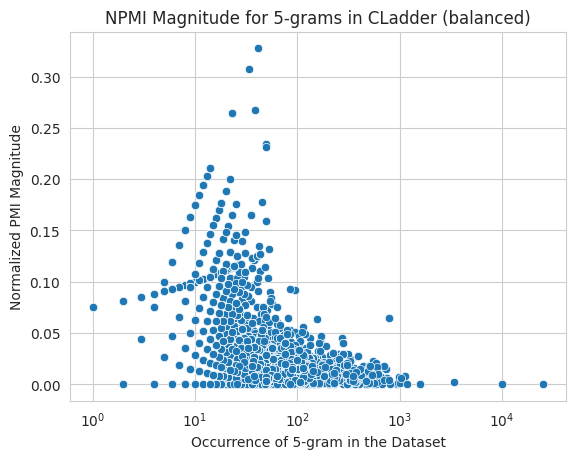

In [394]:
# plot occurence and max_pmi

order = list(max_pmis)
occ = [ngram_freq[ngram] for ngram in order]
mpmi = [max_pmis[ngram] for ngram in order]

sns.scatterplot(x=occ, y=mpmi);
plt.xscale('log')
plt.title(f'NPMI Magnitude for {ngram_n}-grams in CLadder (balanced)')
plt.xlabel(f'Occurrence of {ngram_n}-gram in the Dataset')
plt.ylabel('Normalized PMI Magnitude');
plt.savefig(f'npmi_{ngram_n}.png');

In [332]:
gold = [i for i, (o, m) in enumerate(zip(occ, mpmi)) if o < 5 and 0.001 < m < 0.05]
len(gold)

0

In [340]:
# ind = random.choice(gold)
inds = np.argsort(mpmi)
ind = inds[-10]
print(order[ind])
print(dict(npmi[order[ind]]))
print(dict(ngram_label_freq[order[ind]]))

('allergy', 'case', 'by')
{'no': -0.2110193316619615, 'yes': 0.09299730096955017}
{'no': 1, 'yes': 13}


In [46]:
raw_vals = [v for label_freqs in pmi.values() for v in label_freqs.values()]

/is/ei/fleeb/miniconda3/envs/py10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


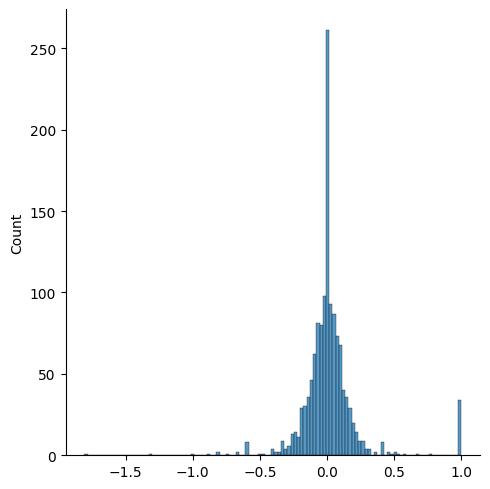

In [47]:
sns.displot(raw_vals, kde=False);

In [16]:

# Sample text and labels
texts = ["I love machine learning", "Machine learning is fun", "I hate math", "Math is challenging"]
labels = [1, 1, 0, 0]  # 1 for positive, 0 for negative

# Extract bi-grams
bi_grams_list = [bigrams(word_tokenize(text)) for text in texts]
flat_bi_grams = [item for sublist in bi_grams_list for item in sublist]

# Compute frequency distribution
freq_dist = FreqDist(flat_bi_grams)
print(freq_dist)


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/is/ei/fleeb/nltk_data'
    - '/is/ei/fleeb/miniconda3/envs/py10/nltk_data'
    - '/is/ei/fleeb/miniconda3/envs/py10/share/nltk_data'
    - '/is/ei/fleeb/miniconda3/envs/py10/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


# Count grammar mistakes

In [29]:

from tqdm.notebook import tqdm
from efficiency.function import avg
import language_tool_python

grammar_tool = language_tool_python.LanguageTool('en-US')
def count_grammar_mistakes(text):
   matches = grammar_tool.check(text)
   return len(matches)

In [38]:

from pathlib import Path
import numpy as np
import random
from collections import Counter
from omnibelt import load_json, save_json

In [31]:
root = Path('../data/backup')
path = root / 'cladder-v1-q-aggregate.json'
path = root / 'cladder-v1-q-commonsense.json'
path = root / 'cladder-v1-q-balanced.json'
# path = '../data/cladder-v1-common-easy.json'
full = load_json(path)
full_ids = {entry['question_id']: entry for entry in full}
models = load_json(root / 'cladder-v1-meta-models.json')
model_table = {info['model_id']: info for info in models}
len(full), len(models)

(10112, 7064)

In [32]:
for entry in full:
	model = models[entry['meta']['model_id']]
	entry['nonsense'] = model.get('nonsense', False)
	entry['anticommonsense'] = 'anticommonsense' in model
	entry['background'] = model['background']

In [48]:
byID = {entry['question_id']: entry for entry in full}

In [33]:
sensical = [e for e in full if not e['nonsense']]
len(sensical)

6270

In [43]:
mistakes = {}
mistake_path = root / 'grammar-mistakes.json'
if mistake_path.exists():
	mistakes = load_json(mistake_path)
len(mistakes)

1

In [53]:
all_prompts = [f'{models[entry["meta"]["model_id"]]["background"]}\n{entry["given_info"]}\n{entry["question"]}' for entry in sensical]
len(all_prompts)

6270

In [45]:
total = 0
n = 0
bar = tqdm(sensical)
for entry in bar:
	n += 1
	if entry['question_id'] in mistakes:
		total += mistakes[entry['question_id']]
		continue
	model = models[entry['meta']['model_id']]
	prompt = f'{model["background"]}\n{entry["given_info"]}\n{entry["question"]}'
	cnt = count_grammar_mistakes(prompt)
	total += cnt
	bar.set_description(f'{total/n:.2f}')
	mistakes[entry['question_id']] = cnt

  0%|          | 0/6270 [00:00<?, ?it/s]

In [46]:
print(f'{sum(mistakes.values()):d}/{len(mistakes):d} = {sum(mistakes.values())/len(mistakes):.2f}')

7808/6271 = 1.25


In [47]:
save_json(mistakes, mistake_path)

In [50]:
common_mistakes = {k: v for k, v in mistakes.items() if not byID[int(k)].get('anticommonsense', False) and not byID[int(k)].get('nonsense', False)}
print(f'{sum(common_mistakes.values()):d}/{len(common_mistakes):d} = {sum(common_mistakes.values())/len(common_mistakes):.2f}')

3413/3142 = 1.09


In [51]:
anti_mistakes = {k: v for k, v in mistakes.items() if byID[int(k)].get('anticommonsense', False)}
print(f'{sum(anti_mistakes.values()):d}/{len(anti_mistakes):d} = {sum(anti_mistakes.values())/len(anti_mistakes):.2f}')

4395/3129 = 1.40


In [54]:
wordcount = [len(prompt.split()) for prompt in all_prompts]
sum(wordcount)

620425

In [58]:
sum(mistakes.values())/sum(wordcount)*100

1.2584921626304548

In [59]:
sum(wordcount)/len(wordcount)

98.95135566188198

In [18]:
entry = sensical[0]
model = models[entry['meta']['model_id']]

In [19]:
prompt = f'{model["background"]}\n{entry["given_info"]}\n{entry["question"]}'

In [23]:
cnt = count_grammar_mistakes(prompt)
cnt

4

In [24]:
print(prompt)

Imagine a self-contained, hypothetical world with only the following conditions, and without any unmentioned factors or causal relationships: Husband has a direct effect on wife and alarm clock. Wife has a direct effect on alarm clock.
For husbands that don't set the alarm and wives that don't set the alarm, the probability of ringing alarm is 8%. For husbands that don't set the alarm and wives that set the alarm, the probability of ringing alarm is 54%. For husbands that set the alarm and wives that don't set the alarm, the probability of ringing alarm is 41%. For husbands that set the alarm and wives that set the alarm, the probability of ringing alarm is 86%. For husbands that don't set the alarm, the probability of alarm set by wife is 74%. For husbands that set the alarm, the probability of alarm set by wife is 24%.
If we disregard the mediation effect through wife, would husband positively affect alarm clock?


In [28]:

cnt = count_grammar_mistakes('These is cool. She think me am cool.')
cnt

2

In [13]:
mistakes = {}


In [5]:

# texts = get_texts() # TODO: Felix, can you exclude the nonsensical, which triggers grammatical errors? Then we can get the count of grammatical errors.
texts = ['These is cool. She think it am cool.',]# 'This is cool', 'He think it is cool.', 'He wants I to think it is cool.']
bar = tqdm(texts)
cnts = []
for text in bar:
   cnt = count_grammar_mistakes(text)
   cnts.append(cnt)
   bar.set_description(str(avg(cnts)))

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
cnts

[2]